### MovieLens Dataset analysis

# Overview
- Reading the data
- Data analysis
- Clean gurbage data
- Data visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from wordcloud import WordCloud, STOPWORDS #used to generate world cloud
pd.set_option('mode.chained_assignment', None)

startTime = time.time()
movies = pd.read_csv("20M/movies.csv")
ratings = pd.read_csv("20M/ratings.csv")
#links = pd.read_csv("20M/links.csv")
tags = pd.read_csv("20M/tags.csv")
# genomeScores = pd.read_csv("20M/genome-scores.csv")
# genomeTags = pd.read_csv("20M/genome-tags.csv")
print("It took %s seconds to load the data" % (time.time() - startTime))

It took 3.815485954284668 seconds to load the data


Exploring the data
As links only contains the url parts, we won't use it in our models

## Data cleaning & analysis

In [2]:
startTime = time.time()
print(movies.shape)
print(ratings.shape)
#print(links.shape)
print(tags.shape)

(27278, 3)
(20000263, 4)
(465564, 4)


In [3]:
movies.isnull().any()

movieId    False
title      False
genres     False
dtype: bool

In [4]:
ratings.isnull().any()

userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

In [5]:
tags.isnull().any()  # tag has some null value, so we will remove it from the dataset

userId       False
movieId      False
tag           True
timestamp    False
dtype: bool

In [6]:
tags = tags.dropna()
tags.isnull().any()

userId       False
movieId      False
tag          False
timestamp    False
dtype: bool

In [7]:
movies['year'] = movies['title'].str.extract('\\(([0-9]+)\\)$', expand = False)
movies

       movieId                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
27273   131254        Kein Bund für's Leben (2007)   
27274   131256       Feuer, Eis & Dosenbier (2002)   
27275   131258                  The Pirates (2014)   
27276   131260                 Rentun Ruusu (2001)   
27277   131262                    Innocence (2014)   

                                            genres  year  
0      Adventure|Animation|Children|Comedy|Fantasy  1995  
1                       Adventure|Children|Fantasy  1995  
2                                   Comedy|Romance  1995  
3                             Comedy|Drama|Romance  1995  
4                                           Comedy  1995

In [8]:
movies.isnull().any()

movieId    False
title      False
genres     False
year        True
dtype: bool

In [9]:
movies = movies.dropna()
movies.isnull().any()  # removing null values

movieId    False
title      False
genres     False
year       False
dtype: bool

In [10]:
movies['year'] = movies['year'].astype(int)
moviesGenres = movies[['year','genres']].copy()
del movies['genres']
del ratings['timestamp']
del tags['timestamp']

Join operations

In [11]:
movies_tags = pd.merge(movies[['movieId', 'title']], tags['movieId'], on='movieId')
movies_ratings_year = pd.merge(movies[['movieId', 'year']], ratings[['movieId', 'rating']], on='movieId')
movies_ratings_title = pd.merge(movies[['movieId', 'title']], ratings[['movieId', 'rating']], on='movieId')

## Data visualization

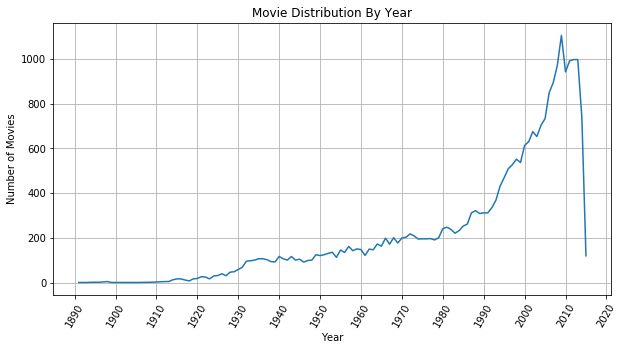

In [12]:
def movies_per_year():
    movie_year_count = movies.groupby('year').count()['movieId']
    plt.figure(figsize=(10,5))
    plt.plot(movie_year_count)
    plt.xticks(np.arange(1890, 2015 + 10, 10), rotation=60)
    plt.grid()
    plt.ylabel("Number of Movies")
    plt.xlabel("Year")
    plt.title("Movie Distribution By Year")
    plt.show()
    

movies_per_year()

#### We can see that the number of movies are increasing over the year. Although after 2010 we can see a little decrease, because there isn't much data of recent years.

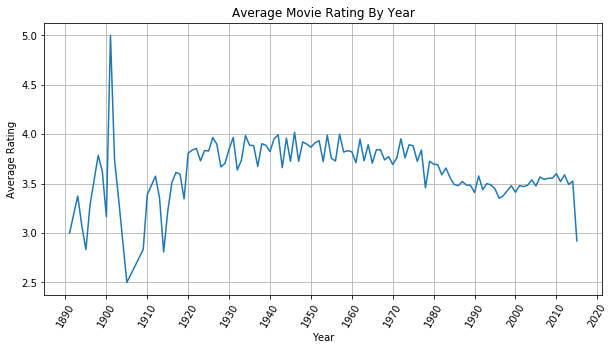

In [13]:
def ratings_per_year():
    avg_rating = movies_ratings_year.groupby('year').rating.mean()
    plt.figure(figsize=(10,5))
    plt.plot(avg_rating)
    plt.xticks(np.arange(1890, 2015 + 10, 10), rotation=60)
    plt.ylabel("Average Rating")
    plt.xlabel("Year")
    plt.title("Average Movie Rating By Year")
    plt.grid()
    plt.show()
    

ratings_per_year()

#### Unlike movie release, we see that the average movie rating by user is getting lower over the years.

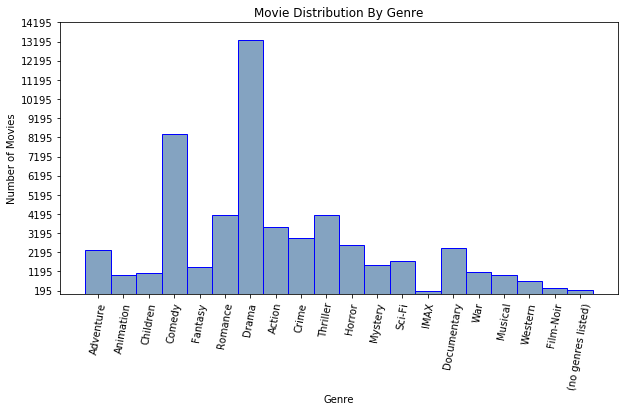

In [14]:
def movies_per_genre():
    moviesGenreCount = dict()
    for val in moviesGenres['genres'].values:
        for genre in val.strip().split('|'):
            if genre in moviesGenreCount:
                moviesGenreCount[genre] += 1
            else:
                moviesGenreCount[genre] = 1
    x, y = moviesGenreCount.keys(), moviesGenreCount.values()  # unpack a list of pairs into two tuples
    plt.figure(figsize=(10,5))
    plt.bar(x, y, width=1.0, facecolor=(0.2, 0.4, 0.6, 0.6), edgecolor='blue')
    plt.xticks(rotation=80)
    plt.yticks(np.arange(min(y), max(y) + 1000, 1000))
    plt.ylabel("Number of Movies")
    plt.xlabel("Genre")
    plt.title("Movie Distribution By Genre")
    plt.show()
    return x
    
    
diffMovieGenres = movies_per_genre()

#### Majority of the movies are either Drama or Comedy

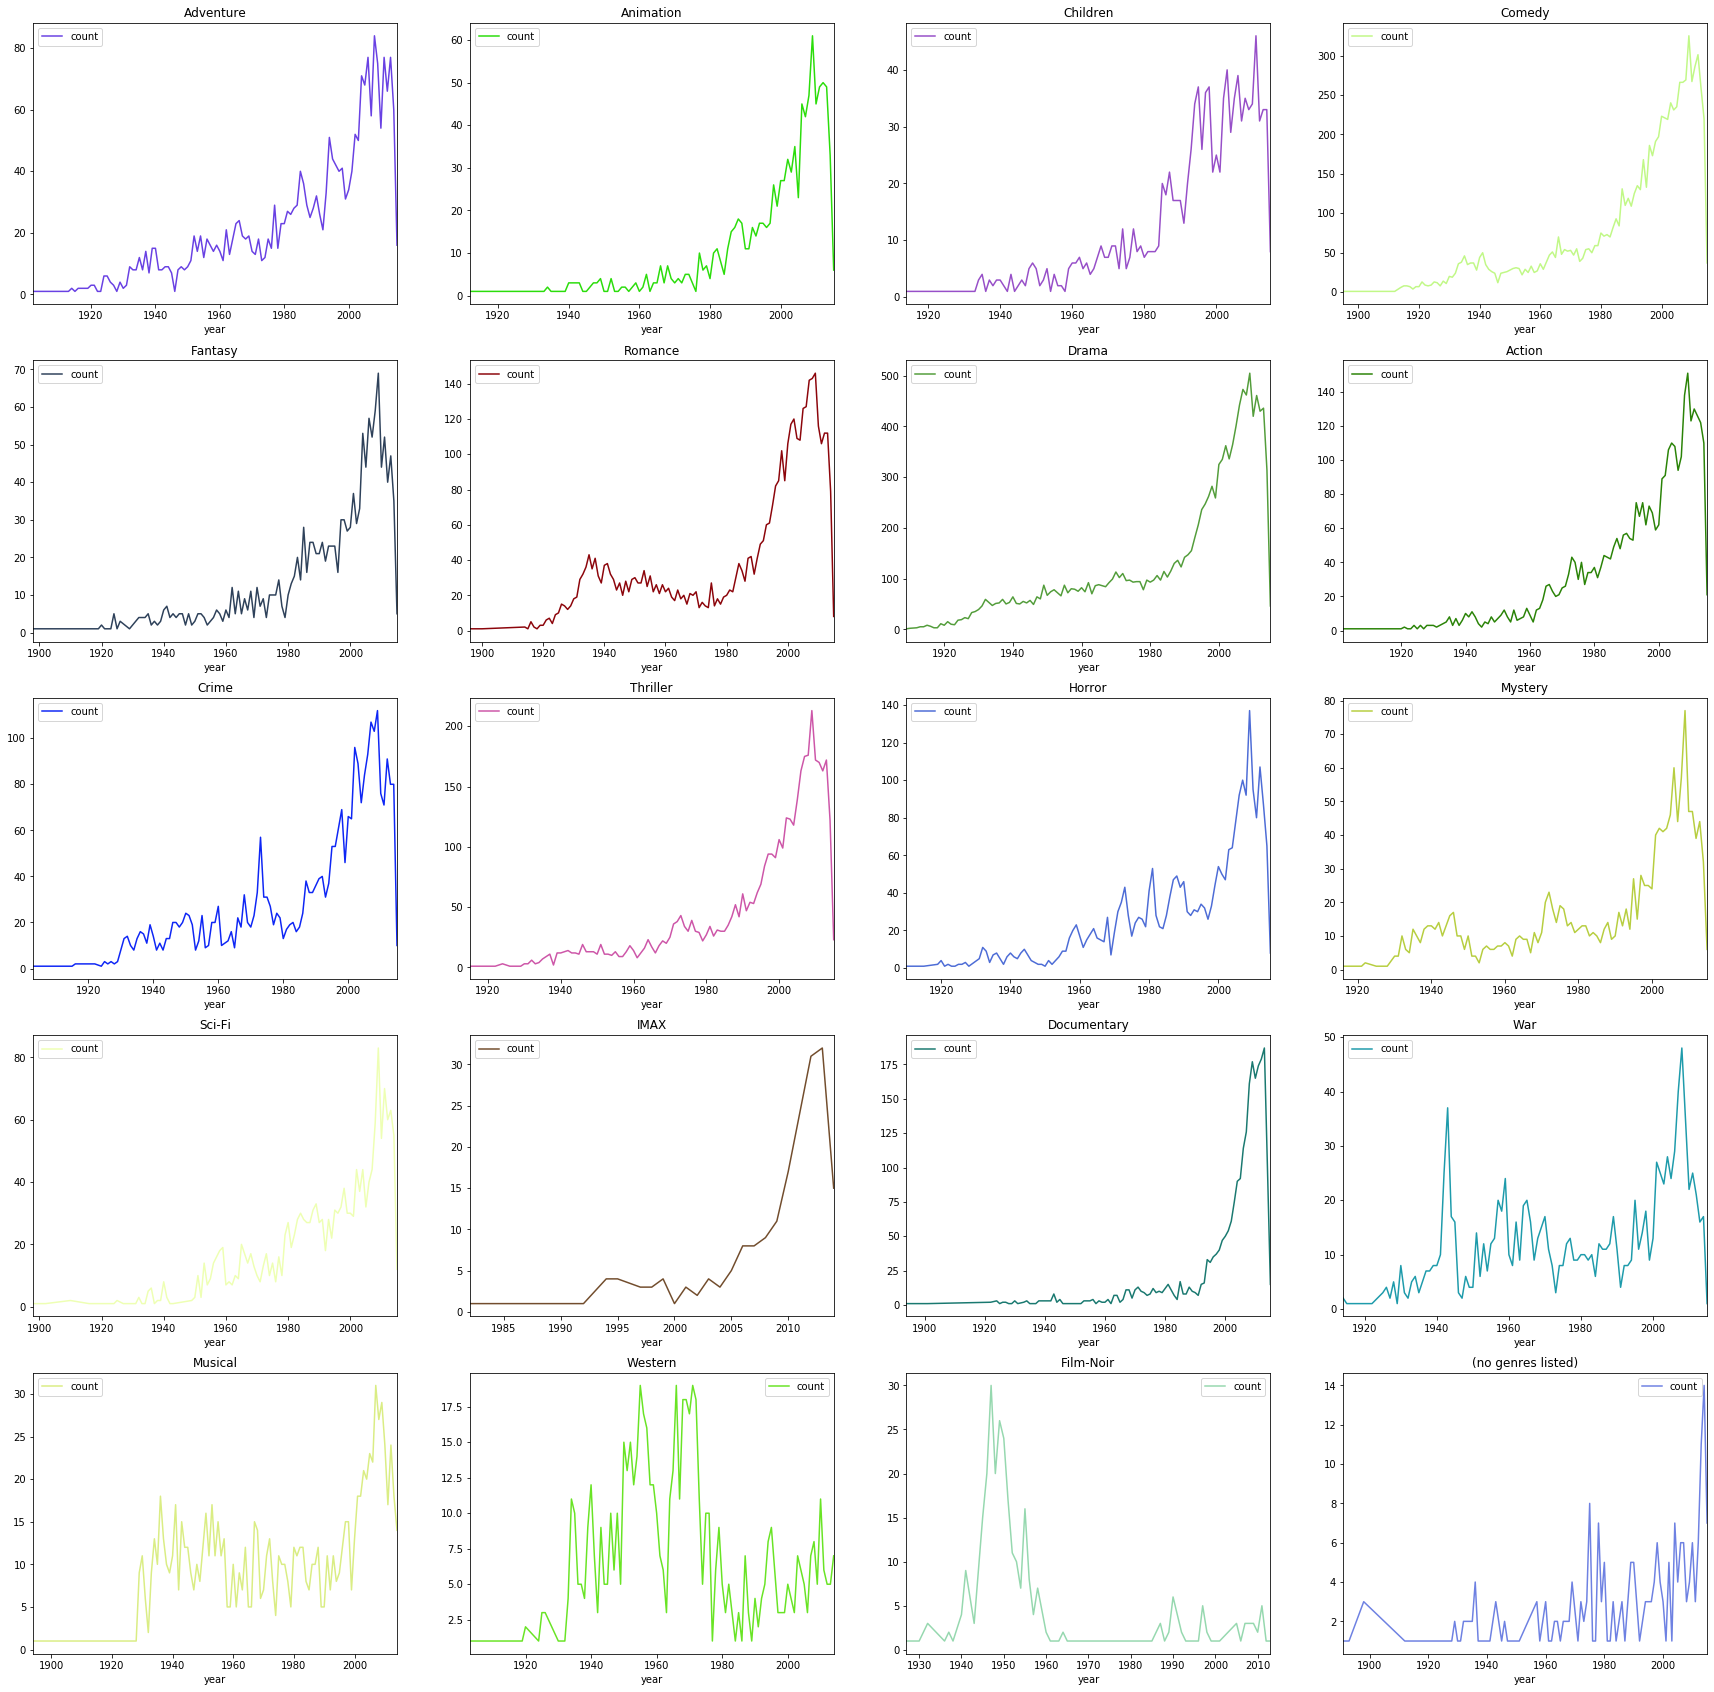

In [21]:
def genre_per_year():
    fig = plt.figure(figsize=(30,30))
    index = 1
    for genre in diffMovieGenres:
        filtered_result = moviesGenres[moviesGenres['genres'].str.contains(genre)]
        result = filtered_result.groupby('year')['genres'].count().reset_index(name="count")
        ax = fig.add_subplot(5, 4, index)
        result.plot(x='year', y='count', title=genre, c=np.random.rand(3, ), ax=ax)
        index += 1
    
genre_per_year()

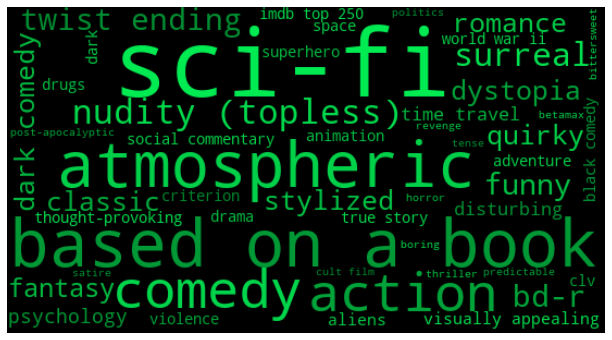

In [16]:
# define a function that counts the number of times each tag appear
def tags_data_parse():
    tag_count = dict()
    for tag in tags['tag']:
        tag = tag.lower()
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1
    tag_count = sorted(tag_count.items(), key = lambda x: x[1], reverse=True)
    return tag_count   


# Function that control the color of the words
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    tone = 100 # define the color of the words
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


def show_most_tagged():
    tag_count = dict(tags_data_parse()[0:50])
    f, ax = plt.subplots(figsize=(15, 6))
    wordcloud = WordCloud(width=550, height=300, background_color='black', 
                          max_words=50, relative_scaling=0.6,
                          color_func = random_color_func,
                          normalize_plurals=True)
    wordcloud.generate_from_frequencies(tag_count)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    
    
show_most_tagged()

#### sci-fi, comedy, based on a book etc. are the most tagged words by the users.

Now we will show the most tagged movie

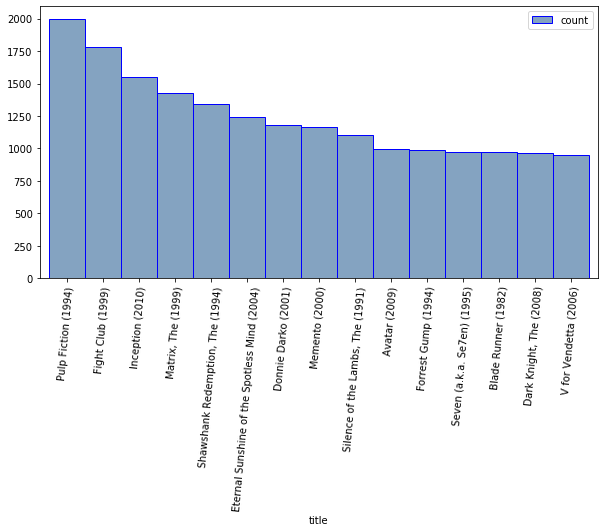

In [17]:
def movie_with_most_tags():
    title_count = movies_tags.groupby('title')["movieId"].count().reset_index(name="count")
    title_count = title_count.sort_values('count', ascending=False)[0:15]
    title_count.plot.bar(x='title', y='count', width=1.0, facecolor=(0.2, 0.4, 0.6, 0.6), edgecolor='blue', figsize=(10,5), rot=85)
    
    
movie_with_most_tags()

#### Pulp Fiction(1994) is the most tagged movie in the survey.

Most rated movies(popular)
Average rating of the most rated movies

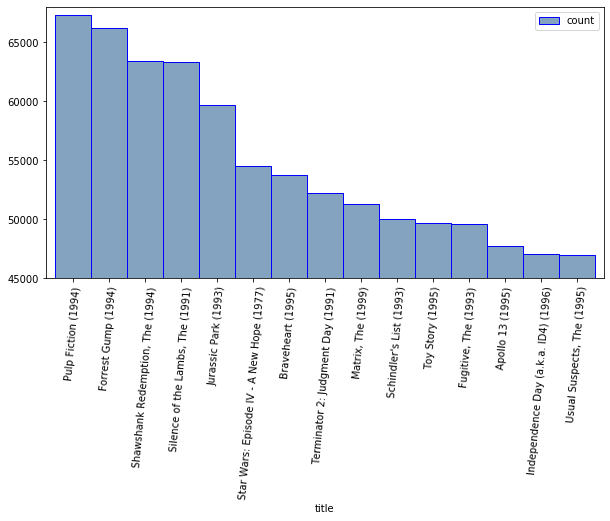

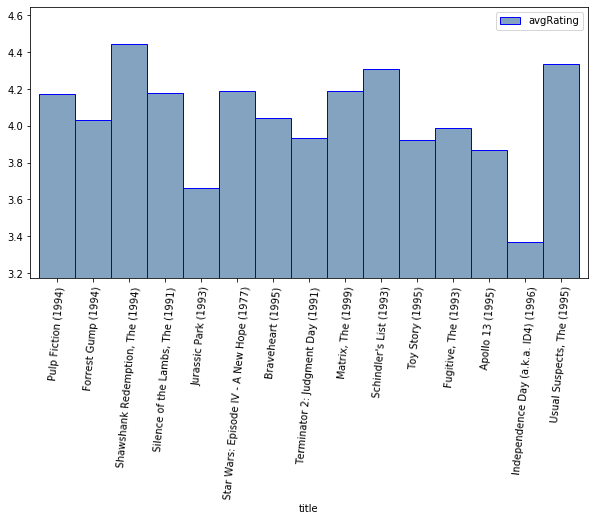

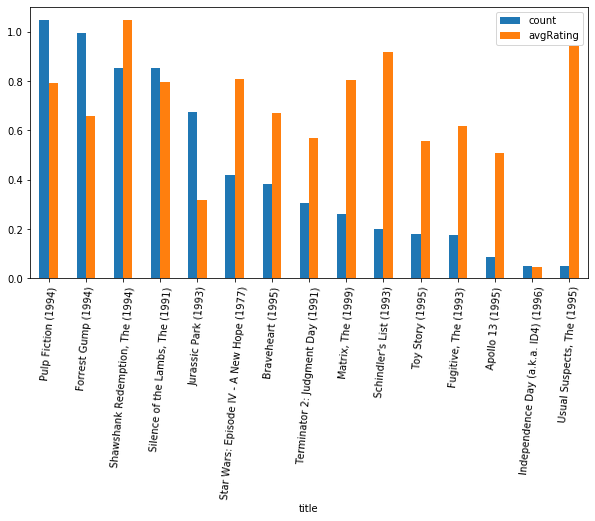

In [18]:
def movie_with_most_user_rating():
    rating_count = movies_ratings_title.groupby(['title'])['movieId'].count().to_frame('count').reset_index()
    avg_rating = movies_ratings_title.groupby(['title'])['rating'].mean().to_frame('avgRating').reset_index()
    most_rated_movies = rating_count.sort_values('count', ascending=False)[0:15]
    top_avg_rating = pd.merge(most_rated_movies[['title','count']], avg_rating[['title','avgRating']], on='title')
    top_avg_rating.plot.bar(x='title', y='count', ylim=(45000, 68000),
                            width=1.0, figsize=(10,5), facecolor=(0.2, 0.4, 0.6, 0.6), edgecolor='blue', rot=85)
    top_avg_rating.plot.bar(x='title', y='avgRating', ylim=(min(top_avg_rating.avgRating)-0.2, max(top_avg_rating.avgRating)+0.2),
                            width=1.0, figsize=(10,5), facecolor=(0.2, 0.4, 0.6, 0.6), edgecolor='blue', rot=85)
    top_avg_rating[['count']] = top_avg_rating[['count']].apply(lambda x: (x - x.min() + 1000) / (x.max() - x.min()))
    top_avg_rating[['avgRating']] = top_avg_rating[['avgRating']].apply(lambda x: (x - x.min() + .05) / (x.max() - x.min()))
    top_avg_rating.plot.bar(x='title', y=['count','avgRating'], figsize=(10,5), rot=85)

movie_with_most_user_rating()

#### Similar to the most tagged result, we can see that the Pulp Fiction(1994) is the most rated movie in the survey. Independence Day(a.k.a. ID4) (1996) and Jurassic Park(1993) are among the most rated movies, but their average ratings are comparatively lower.

#### We can also observe that, Forrest Gump(1994) is in the most rated movies, but not in the most tagged. On the otherhand, Fight Club(1999) is in the most tagged movies, but not in the most rated.

Rating summary

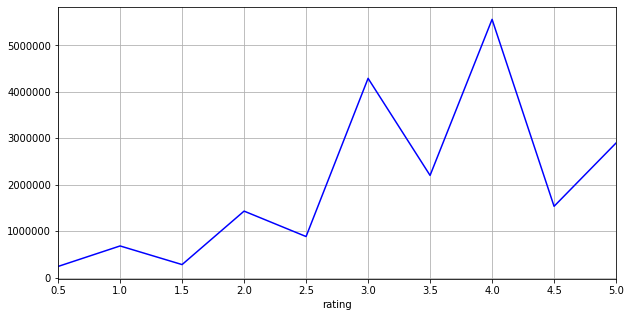

In [19]:
def rating_summary():
    avg_rating = ratings.groupby('rating')['movieId'].count()
    avg_rating.plot(grid=True, figsize=(10,5), color='blue')
    
rating_summary()

#### As we can see, most of the movies were rated 4.0 in the survey.

In [20]:
print("It took %s seconds to process the data" % (time.time() - startTime))

It took 17.564723014831543 seconds to process the data
